In [22]:
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
%matplotlib inline

In [23]:
data_train=np.loadtxt("mnist_train.txt",delimiter=",")
y_train,X_train = data_train[:,0],data_train[:,1:]
data_test=np.loadtxt("mnist_test.txt",delimiter=",")
y_test,X_test = data_test[:,0],data_test[:,1:]

Question 3a)

Featurizing the data to be between -1 and 1

In [24]:
X_train = 2*(X_train/255 - 0.5)
X_test = 2*(X_test/255 - 0.5)

Question 3b)

In [44]:
def pegasos_svm_train(K,y,Lambda=2**-8):
    alpha = np.zeros(y.shape[0])
    t=0
    for iter in range(0,50):
        for index in range(0,y.shape[0]):
            j = np.random.randint(y.shape[0])
            yj = y[j]
            t=t+1
            eta = 1/(t*Lambda)
            if yj*(K[j,:].T@alpha) < 1:
                alpha = (1-eta*Lambda)*alpha
                alpha[j] = (1-eta*Lambda)*alpha[j] + eta*yj
            else:
                alpha = (1-eta*Lambda)*alpha
    return alpha

This is a generlaized kernel prediction method which is calculated using X as the training vector, Z as the data point to be predicted which is predicted using alpha.phi(Xi).phi(Z)

In [26]:
def phi(X):
    return X

In [27]:
def kernelized_pred(X,Z,alpha):
    yhat = np.zeros(Z.shape[0])
    for i in range(Z.shape[0]):
        K = phi(X)@phi(Z[i,:])
        yhat[i] = alpha.T@K
    return yhat 

In [28]:
def kernelized_weights(alpha,X):
    w = np.zeros(X.shape[1])
    for i in range(alpha.shape[0]):
        w = w+alpha[i]*X[i,:]
    return w.T
    

Calculating the linear kernel

In [15]:
linear_kernel = X_train@X_train.T

In [16]:
yhats = np.zeros((X_train.shape[0],10))
ws = np.zeros((X_train.shape[1],10))
for number in range (10):
    y_temp = np.array(y_train)
    y_temp[y_train!=number] = -1
    y_temp[y_train==number] = 1
    alpha = pegasos_svm_train(linear_kernel,y_temp)
    yhats[:,number] = kernelized_pred(X_train,X_train,alpha)

    

Finding the indexes of the maximum scores

In [20]:
y_pred = np.argmax(yhats,axis=1)
print("The labels are " + str(y_pred))

The labels are [3 5 0 ... 2 9 3]


In [19]:
print("Training accuracy " + str(np.mean(y_pred==y_train)))

Training accuracy 0.984


Quetsion 3c) 

In [51]:
lambdas = 2**np.arange(5,0,-1)
kf = KFold(n_splits=5)
e=[]
for l in lambdas:
    e_temp=[]
    for train,test in kf.split(X_train):
        X = X_train[train,:]
        y = y_train[train]
        X_test1 = X_train[test,:]
        y_test1 = y_train[test]
        yhats = np.zeros((X_test1.shape[0],10))
        ws = np.zeros((X_train.shape[1],10))
        linear_kernel = X@X.T
        for number in range (10):
            y_temp = np.array(y)
            y_temp[y!=number] = -1
            y_temp[y==number] = 1
            alpha = pegasos_svm_train(linear_kernel,y_temp,Lambda=l)
            yhats[:,number] = kernelized_pred(X,X_test1,alpha)
        y_pred = np.argmax(yhats,axis=1)
        e_temp.append(np.mean(y_pred!=y_test1))
    error=np.mean(np.array(e_temp))
    e.append(error)    

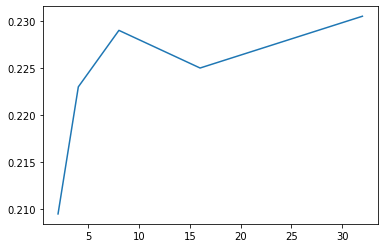

In [52]:
plt.plot(lambdas,e)
plt.show()

In [53]:
print("Best Lambda = " + str(lambdas[np.argmin(e)]))

Best Lambda = 2


In [49]:
yhats = np.zeros((X_test.shape[0],10))
linear_kernel=X_train@X_train.T
for number in range (10):
    y_temp = np.array(y_train)
    y_temp[y_train!=number] = -1
    y_temp[y_train==number] = 1
    alpha = pegasos_svm_train(X_train@X_train.T,y_temp,Lambda=2.**1)
    #w = kernelized_weights(alpha,X_train)
    yhats[:,number] = kernelized_pred(X_train,X_test,alpha)
y_pred = np.argmax(yhats,axis=1)
print("Test accuracy " + str(np.mean(y_pred==y_test)))

Test accuracy 0.817


In [50]:
print("Test error " + str(100*np.mean(y_pred!=y_test)))

Test error 18.3


Question 3d)

x_train and x_test are already between -1 and 1

In [68]:
num_features = X_train.shape[1]
gamma = 1/num_features
C=1
svc = OneVsRestClassifier(SVC(gamma=gamma,C=C))
svc.fit(X_train,y_train)

OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma=0.0012755102040816326,
                                  kernel='rbf', max_iter=-1, probability=False,
                                  random_state=None, shrinking=True, tol=0.001,
                                  verbose=False),
                    n_jobs=None)

In [71]:
yhat = svc.predict(X_test)
print("Test error is " + str(np.mean(yhat!=y_test)))

Test error is 0.09


Question 3e)

In [75]:
def cross_validation_error(gamma,C):
    kf = KFold(n_splits=10)
    e=[]
    svc = OneVsRestClassifier(SVC(gamma=gamma,C=C))
    for train,test in kf.split(X_train):
        Xtr = X_train[train,:]
        ytr = y_train[train]
        Xts = X_train[test,:]
        yts = y_train[test]
        svc.fit(Xtr,ytr)
        yhat = svc.predict(Xts)
        e.append(np.mean(yhat!=yts))
    return np.mean(e)
    

In [76]:
print("Cross validation error for default settings is " + str(cross_validation_error(gamma,C)))

Cross validation error for default settings is 0.0945


Question 3f)

In [5]:
gamma = 10.**np.arange(0,-5,-1)
C = np.array([0.01,0.1,1,2,3,4,5])
param_grid = {"gamma" : gamma, "C":C}

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import accuracy_score, make_scorer

clf = GridSearchCV(SVC(),param_grid,return_train_score=True,cv=10,refit=True,scoring = make_scorer(accuracy_score,greater_is_better=True))
    

In [7]:
clf.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.01, 0.1 , 1.  , 2.  , 3.  , 4.  , 5.  ]),
                         'gamma': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(accuracy_score), verbose=0)

In [10]:
print("Cross validation error after tuning C and gamma is " + str(100*(1-clf.best_score_)))

Cross validation error after tuning C and gamma is 5.449999999999999


In [13]:
c_best = clf.best_params_['C']
gamma_best = clf.best_params_['gamma']
print("Best Value of C is " + str(c_best) )
print("Best Value of gamma is " + str(gamma_best) )

Best Value of C is 2.0
Best Value of C is 0.01


In [15]:
svm = SVC(gamma=gamma_best,C=c_best)
svm.fit(X_train,y_train)
yhat = svm.predict(X_test)
print("Accuracy on test set " + str(np.mean(yhat==y_test)))
print("Error on test set " + str(np.mean(yhat!=y_test)))

Accuracy on test set 0.946
Error on test set 0.054
